In [ ]:
#default_exp data.transforms

In [ ]:
#export
from fastai2.torch_basics import *
from fastai2.test import *
from fastai2.data.core import *
from fastai2.data.load import *
from fastai2.data.external import *

In [ ]:
from nbdev.showdoc import *

# Helper functions for processing data and basic transforms

> Functions for getting, splitting, and labeling data, as well as generic transforms

## Get, split, and label

For most data source creation we need functions to get a list of items, split them in to train/valid sets, and label them. fastai provides functions to make each of these steps easy (especially when combined with `fastai.data.blocks`).

### Get

First we'll look at functions that *get* a list of items (generally file names).

We'll use *tiny MNIST* (a subset of MNIST with just two classes, `7`s and `3`s) for our examples/tests throughout this page.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
(path/'train').ls()

(#2) [/home/sgugger/.fastai/data/mnist_tiny/train/3,/home/sgugger/.fastai/data/mnist_tiny/train/7]

In [ ]:
# export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [ ]:
# export
def get_files(path, extensions=None, recurse=True, folders=None):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    folders=L(folders)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return L(res)

This is the most general way to grab a bunch of file names from disk. If you pass `extensions` (including the `.`) then returned file names are filtered by that list. Only those files directly in `path` are included, unless you pass `recurse`, in which case all child folders are also searched recursively. `folders` is an optional list of directories to limit the search to.

In [ ]:
t3 = get_files(path/'train'/'3', extensions='.png', recurse=False)
t7 = get_files(path/'train'/'7', extensions='.png', recurse=False)
t  = get_files(path/'train', extensions='.png', recurse=True)
test_eq(len(t), len(t3)+len(t7))
test_eq(len(get_files(path/'train'/'3', extensions='.jpg', recurse=False)),0)
test_eq(len(t), len(get_files(path, extensions='.png', recurse=True, folders='train')))
t

(#709) [/home/sgugger/.fastai/data/mnist_tiny/train/3/8055.png,/home/sgugger/.fastai/data/mnist_tiny/train/3/9466.png,/home/sgugger/.fastai/data/mnist_tiny/train/3/7778.png,/home/sgugger/.fastai/data/mnist_tiny/train/3/8824.png,/home/sgugger/.fastai/data/mnist_tiny/train/3/8228.png,/home/sgugger/.fastai/data/mnist_tiny/train/3/9620.png,/home/sgugger/.fastai/data/mnist_tiny/train/3/8790.png,/home/sgugger/.fastai/data/mnist_tiny/train/3/7497.png,/home/sgugger/.fastai/data/mnist_tiny/train/3/7383.png,/home/sgugger/.fastai/data/mnist_tiny/train/3/9324.png...]

In [ ]:
#hide
test_eq(len(get_files(path/'train'/'3', recurse=False)),346)
test_eq(len(get_files(path, extensions='.png', recurse=True, folders=['train', 'test'])),729)
test_eq(len(get_files(path, extensions='.png', recurse=True, folders='train')),709)
test_eq(len(get_files(path, extensions='.png', recurse=True, folders='training')),0)

It's often useful to be able to create functions with customized behavior. `fastai.data` generally uses functions named as CamelCase verbs ending in `er` to create these functions. `FileGetter` is a simple example of such a function creator.

In [ ]:
#export
def FileGetter(suf='', extensions=None, recurse=True, folders=None):
    "Create `get_files` partial function that searches path suffix `suf`, only in `folders`, if specified, and passes along args"
    def _inner(o, extensions=extensions, recurse=recurse, folders=folders):
        return get_files(o/suf, extensions, recurse, folders)
    return _inner

In [ ]:
fpng = FileGetter(extensions='.png', recurse=False)
test_eq(len(t7), len(fpng(path/'train'/'7')))
test_eq(len(t), len(fpng(path/'train', recurse=True)))
fpng_r = FileGetter(extensions='.png', recurse=True)
test_eq(len(t), len(fpng_r(path/'train')))

In [ ]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [ ]:
#export
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)

This is simply `get_files` called with a list of standard image extensions.

In [ ]:
test_eq(len(t), len(get_image_files(path, recurse=True, folders='train')))

In [ ]:
#export
def ImageGetter(suf='', recurse=True, folders=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`, only in `folders`, if specified."
    def _inner(o, recurse=recurse, folders=folders): return get_image_files(o/suf, recurse, folders)
    return _inner

Same as `FileGetter`, but for image extensions.

In [ ]:
test_eq(len(get_files(path/'train', extensions='.png', recurse=True, folders='3')),
        len(ImageGetter(   'train',                    recurse=True, folders='3')(path)))

In [ ]:
#export
def get_text_files(path, recurse=True, folders=None):
    "Get text files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=['.txt'], recurse=recurse, folders=folders)

### Split

The next set of functions are used to *split* data into training and validation sets. The functions return two lists - a list of indices or masks for each of training and validation sets.

In [ ]:
# export
def RandomSplitter(valid_pct=0.2, seed=None, **kwargs):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o, **kwargs):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner

In [ ]:
src = list(range(30))
f = RandomSplitter(seed=42)
trn,val = f(src)
assert 0<len(trn)<len(src)
assert all(o not in val for o in trn)
test_eq(len(trn), len(src)-len(val))
# test random seed consistency
test_eq(f(src)[0], trn)

In [ ]:
#export
def IndexSplitter(valid_idx):
    "Split `items` so that `val_idx` are in the validation set and the others in the training set"
    def _inner(o, **kwargs):
        train_idx = np.setdiff1d(np.array(range_of(o)), np.array(valid_idx))
        return train_idx,valid_idx
    return _inner

In [ ]:
items = list(range(10))
splitter = IndexSplitter([3,7,9])
test_eq(splitter(items),[[0,1,2,4,5,6,8],[3,7,9]])

In [ ]:
# export
def _grandparent_idxs(items, name): return mask2idxs(Path(o).parent.parent.name == name for o in items)

In [ ]:
# export
def GrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o, **kwargs):
        return _grandparent_idxs(o, train_name),_grandparent_idxs(o, valid_name)
    return _inner

In [ ]:
fnames = [path/'train/3/9932.png', path/'valid/7/7189.png', 
          path/'valid/7/7320.png', path/'train/7/9833.png',  
          path/'train/3/7666.png', path/'valid/3/925.png',
          path/'train/7/724.png', path/'valid/3/93055.png']
splitter = GrandparentSplitter()
test_eq(splitter(fnames),[[0,3,4,6],[1,2,5,7]])

In [ ]:
# export
def FuncSplitter(func):
    "Split `items` by result of `func` (`True` for validation, `False` for training set)."
    def _inner(o, **kwargs):
        val_idx = mask2idxs(func(o_) for o_ in o)
        return IndexSplitter(val_idx)(o)
    return _inner

In [ ]:
splitter = FuncSplitter(lambda o: Path(o).parent.parent.name == 'valid')
test_eq(splitter(fnames),[[0,3,4,6],[1,2,5,7]])

In [ ]:
# export
def MaskSplitter(mask):
    "Split `items` depending on the value of `mask`."
    def _inner(o, **kwargs): return IndexSplitter(mask2idxs(mask))(o)
    return _inner

In [ ]:
items = list(range(6))
splitter = MaskSplitter([True,False,False,True,False,True])
test_eq(splitter(items),[[1,2,4],[0,3,5]])

In [ ]:
# export
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [ ]:
with tempfile.TemporaryDirectory() as d:
    fname = Path(d)/'valid.txt'
    fname.write('\n'.join([Path(fnames[i]).name for i in [1,3,4]]))
    splitter = FileSplitter(fname)
    test_eq(splitter(fnames),[[0,2,5,6,7],[1,3,4]])

### Label

The final set of functions is used to *label* a single item of data.

In [ ]:
# export
def parent_label(o, **kwargs):
    "Label `item` with the parent folder name."
    return Path(o).parent.name

Note that `parent_label` doesn't have anything customize, so it doesn't return a function - you can just use it directly.

In [ ]:
test_eq(parent_label(fnames[0]), '3')
test_eq(parent_label("fastai_dev/dev/data/mnist_tiny/train/3/9932.png"), '3')
[parent_label(o) for o in fnames]

['3', '7', '7', '7', '3', '3', '7', '3']

In [ ]:
#hide
#test for MS Windows when os.path.sep is '\\' instead of '/'
test_eq(parent_label(os.path.join("fastai_dev","dev","data","mnist_tiny","train", "3", "9932.png") ), '3')

In [ ]:
# export
class RegexLabeller():
    "Label `item` with regex `pat`."
    def __init__(self, pat): self.pat = re.compile(pat)
        
    def __call__(self, o, **kwargs):
        res = self.pat.search(str(o))
        assert res,f'Failed to find "{self.pat}" in "{o}"'
        return res.group(1)

`RegexLabeller` is a very flexible function since it handles any regex search of the stringified item. For instance, here's an example the replicates the previous `parent_label` results.

In [ ]:
regexp = re.compile(f'{re.escape(os.path.sep)}(\d){re.escape(os.path.sep)}')
f = RegexLabeller(regexp)
test_eq(parent_label(fnames[0]), '3')
[f(o) for o in fnames]

['3', '7', '7', '7', '3', '3', '7', '3']

In [ ]:
#export
class ColReader():
    "Read `cols` in `row` with potnetial `pref` and `suff`"
    def __init__(self, cols, pref='', suff='', label_delim=None):
        store_attr(self, 'suff,label_delim')
        self.pref = str(pref) + os.path.sep if isinstance(pref, Path) else pref
        self.cols = L(cols)
    
    def _do_one(self, r, c):
        o = r[c] if isinstance(c, int) else getattr(r, c)
        if len(self.pref)==0 and len(self.suff)==0 and self.label_delim is None: return o
        if self.label_delim is None: return f'{self.pref}{o}{self.suff}'
        else: return o.split(self.label_delim) if len(o)>0 else []
    
    def __call__(self, o, **kwargs): return detuplify(tuple(self._do_one(o, c) for c in self.cols))

`cols` can be a list of column names or a list of indices (or a mix of both). If `label_delim` is passed, the result is split using it.

In [ ]:
df = pd.DataFrame({'a': 'a b c d'.split(), 'b': ['1 2', '0', '', '1 2 3']})
f = ColReader('a', pref='0', suff='1')
test_eq([f(o) for o in df.itertuples()], '0a1 0b1 0c1 0d1'.split())

f = ColReader('b', label_delim=' ')
test_eq([f(o) for o in df.itertuples()], [['1', '2'], ['0'], [], ['1', '2', '3']])

df['a1'] = df['a']
f = ColReader(['a', 'a1'], pref='0', suff='1')
test_eq([f(o) for o in df.itertuples()], [('0a1', '0a1'), ('0b1', '0b1'), ('0c1', '0c1'), ('0d1', '0d1')])

df = pd.DataFrame({'a': [L(0,1), L(2,3,4), L(5,6,7)]})
f = ColReader('a')
test_eq([f(o) for o in df.itertuples()], [L(0,1), L(2,3,4), L(5,6,7)])

## Categorize -

In [ ]:
#export
class CategoryMap(CollBase):
    "Collection of categories with the reverse mapping in `o2i`"
    def __init__(self, col, sort=True, add_na=False):
        if is_categorical_dtype(col): items = L(col.cat.categories, use_list=True)
        else:
            if not hasattr(col,'unique'): col = L(col, use_list=True)
            # `o==o` is the generalized definition of non-NaN used by Pandas
            items = L(o for o in col.unique() if o==o)
            if sort: items = items.sorted()
        self.items = '#na#' + items if add_na else items
        self.o2i = defaultdict(int, self.items.val2idx()) if add_na else dict(self.items.val2idx())
    def __eq__(self,b): return all_equal(b,self)

In [ ]:
t = CategoryMap([4,2,3,4])
test_eq(t, [2,3,4])
test_eq(t.o2i, {2:0,3:1,4:2})
test_fail(lambda: t.o2i['unseen label'])

In [ ]:
t = CategoryMap([4,2,3,4], add_na=True)
test_eq(t, ['#na#',2,3,4])
test_eq(t.o2i, {'#na#':0,2:1,3:2,4:3})

In [ ]:
t = CategoryMap(pd.Series([4,2,3,4]), sort=False)
test_eq(t, [4,2,3])
test_eq(t.o2i, {4:0,2:1,3:2})

In [ ]:
col = pd.Series(pd.Categorical(['M','H','L','M'], categories=['H','M','L'], ordered=True))
t = CategoryMap(col)
test_eq(t, ['H','M','L'])
test_eq(t.o2i, {'H':0,'M':1,'L':2})

In [ ]:
# export
class Categorize(Transform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, add_na=False):
        self.add_na = add_na
        self.vocab = None if vocab is None else CategoryMap(vocab, add_na=add_na)

    def setups(self, dsrc):
        if self.vocab is None and dsrc is not None: self.vocab = CategoryMap(dsrc, add_na=self.add_na)
        self.c = len(self.vocab)

    def encodes(self, o): return TensorCategory(self.vocab.o2i[o])
    def decodes(self, o): return Category      (self.vocab    [o])

In [ ]:
#export
class Category(str, ShowTitle): _show_args = {'label': 'category'}

In [ ]:
cat = Categorize()
tds = DataSource(['cat', 'dog', 'cat'], tfms=[cat])
test_eq(cat.vocab, ['cat', 'dog'])
test_eq(cat('cat'), 0)
test_eq(cat.decode(1), 'dog')
test_stdout(lambda: show_at(tds,2), 'cat')

In [ ]:
cat = Categorize(add_na=True)
tds = DataSource(['cat', 'dog', 'cat'], tfms=[cat])
test_eq(cat.vocab, ['#na#', 'cat', 'dog'])
test_eq(cat('cat'), 1)
test_eq(cat.decode(2), 'dog')
test_stdout(lambda: show_at(tds,2), 'cat')

## Multicategorize -

In [ ]:
# export
class MultiCategorize(Categorize):
    "Reversible transform of multi-category strings to `vocab` id"
    loss_func,order=BCEWithLogitsLossFlat(),1
    def __init__(self, vocab=None, add_na=False):
        self.add_na = add_na
        self.vocab = None if vocab is None else CategoryMap(vocab, add_na=add_na)
        
    def setups(self, dsrc):
        if not dsrc: return
        if self.vocab is None:
            vals = set()
            for b in dsrc: vals = vals.union(set(b))
            self.vocab = CategoryMap(list(vals), add_na=self.add_na)

    def encodes(self, o): return TensorMultiCategory([self.vocab.o2i[o_] for o_ in o])
    def decodes(self, o): return MultiCategory      ([self.vocab    [o_] for o_ in o])

In [ ]:
#export
class MultiCategory(L):
    def show(self, ctx=None, sep=';', color='black', **kwargs):
        return show_title(sep.join(self.map(str)), ctx=ctx, color=color, **kwargs)

In [ ]:
cat = MultiCategorize()
tds = DataSource([['b', 'c'], ['a'], ['a', 'c'], []], tfms=[cat])
test_eq(tds[3][0], tensor([]))
test_eq(cat.vocab, ['a', 'b', 'c'])
test_eq(cat(['a', 'c']), tensor([0,2]))
test_eq(cat([]), tensor([]))
test_eq(cat.decode([1]), ['b'])
test_eq(cat.decode([0,2]), ['a', 'c'])
test_stdout(lambda: show_at(tds,2), 'a;c')

In [ ]:
# export
class OneHotEncode(Transform):
    "One-hot encodes targets"
    order=2
    def __init__(self, c=None): self.c = c

    def setups(self, dsrc):
        if self.c is None: self.c = len(L(getattr(dsrc, 'vocab', None)))
        if not self.c: warn("Couldn't infer the number of classes, please pass a value for `c` at init")

    def encodes(self, o): return TensorMultiCategory(one_hot(o, self.c).float())
    def decodes(self, o): return one_hot_decode(o, None)

Works in conjunction with ` MultiCategorize` or on its own if you have one-hot encoded targets (pass a `vocab` for decoding and `do_encode=False` in this case)

In [ ]:
_tfm = OneHotEncode(c=3)
test_eq(_tfm([0,2]), tensor([1.,0,1]))
test_eq(_tfm.decode(tensor([0,1,1])), [1,2])

In [ ]:
tds = DataSource([['b', 'c'], ['a'], ['a', 'c'], []], [[MultiCategorize(), OneHotEncode()]])
test_eq(tds[1], [tensor([1.,0,0])])
test_eq(tds[3], [tensor([0.,0,0])])
test_eq(tds.decode([tensor([False, True, True])]), [['b','c']])
test_eq(type(tds[1][0]), TensorMultiCategory)
test_stdout(lambda: show_at(tds,2), 'a;c')

In [ ]:
#hide
#test with passing the vocab
tds = DataSource([['b', 'c'], ['a'], ['a', 'c'], []], [[MultiCategorize(vocab=['a', 'b', 'c']), OneHotEncode()]])
test_eq(tds[1], [tensor([1.,0,0])])
test_eq(tds[3], [tensor([0.,0,0])])
test_eq(tds.decode([tensor([False, True, True])]), [['b','c']])
test_eq(type(tds[1][0]), TensorMultiCategory)
test_stdout(lambda: show_at(tds,2), 'a;c')

In [ ]:
# export
class EncodedMultiCategorize(Categorize):
    "Transform of one-hot encoded multi-category that decodes with `vocab`"
    loss_func,order=BCEWithLogitsLossFlat(),1
    def __init__(self, vocab): self.vocab,self.c = vocab,len(vocab)
    def encodes(self, o): return TensorCategory(tensor(o).float())
    def decodes(self, o): return MultiCategory (one_hot_decode(o, self.vocab))

In [ ]:
_tfm = EncodedMultiCategorize(vocab=['a', 'b', 'c'])
test_eq(_tfm([1,0,1]), tensor([1., 0., 1.]))
test_eq(type(_tfm([1,0,1])), TensorCategory)
test_eq(_tfm.decode(tensor([False, True, True])), ['b','c'])

In [ ]:
#export
def get_c(dbunch):
    if getattr(dbunch, 'c', False): return dbunch.c
    vocab = getattr(dbunch, 'vocab', [])
    if len(vocab) > 0 and is_listy(vocab[-1]): vocab = vocab[-1]
    return len(vocab)

## End-to-end dataset example with MNIST

Let's show how to use those functions to grab the mnist dataset in a `DataSource`. First we grab all the images.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)

Then we split between train and validation depending on the folder.

In [ ]:
splitter = GrandparentSplitter()
splits = splitter(items)
train,valid = (items[i] for i in splits)
train[:3],valid[:3]

((#3) [/home/jhoward/.fastai/data/mnist_tiny/train/7/723.png,/home/jhoward/.fastai/data/mnist_tiny/train/7/7446.png,/home/jhoward/.fastai/data/mnist_tiny/train/7/8566.png],
 (#3) [/home/jhoward/.fastai/data/mnist_tiny/valid/7/946.png,/home/jhoward/.fastai/data/mnist_tiny/valid/7/9608.png,/home/jhoward/.fastai/data/mnist_tiny/valid/7/825.png])

Our inputs are images that we open and convert to tensors, our targets are labeled depending on the parent directory and are categories.

In [ ]:
from PIL import Image
def open_img(fn:Path): return Image.open(fn).copy()
def img2tensor(im:Image.Image): return TensorImage(array(im)[None])

tfms = [[open_img, img2tensor],
        [parent_label, Categorize()]]
train_ds = DataSource(train, tfms)

In [ ]:
x,y = train_ds[3]
xd,yd = decode_at(train_ds,3)
test_eq(parent_label(train[3]),yd)
test_eq(array(Image.open(train[3])),xd[0].numpy())

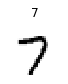

In [ ]:
ax = show_at(train_ds, 3, cmap="Greys", figsize=(1,1))

In [ ]:
assert ax.title.get_text() in ('3','7')
test_fig_exists(ax)

## ToTensor -

In [ ]:
#export
class ToTensor(Transform):
    "Convert item to appropriate tensor class"
    order = 15

## Cuda -

In [ ]:
# export
@docs
class Cuda(Transform):
    "Move batch to `device` (defaults to `default_device()`)"
    def __init__(self,device=None):
        self.device=default_device() if device is None else device
        super().__init__(split_idx=None, as_item=False)
    def encodes(self, b): return to_device(b, self.device)
    def decodes(self, b): return to_cpu(b)

    _docs=dict(encodes="Move batch to `device`", decodes="Return batch to CPU")

In [ ]:
show_doc(Cuda.encodes, name='Cuda.encodes')

<h4 id="Cuda.encodes" class="doc_header"><code>Cuda.encodes</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L8" class="source_link" style="float:right">[source]</a></h4>

> <code>Cuda.encodes</code>()

Move batch to [`device`](https://pytorch.org/docs/stable/tensor_attributes.html#torch-device)

Note that, like all `Transform`s, `encodes` is called by `tfm()` and `decodes` is called by `tfm.decode()`.

In [ ]:
tfm = Cuda()
t = tfm((tensor(1),))
test_eq(*t,1)
test_eq(t[0].type(),'torch.cuda.LongTensor' if default_device().type=='cuda' else 'torch.LongTensor')

In [ ]:
show_doc(Cuda.decodes, name='Cuda.decodes')

<h4 id="Cuda.decodes" class="doc_header"><code>Cuda.decodes</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L9" class="source_link" style="float:right">[source]</a></h4>

> <code>Cuda.decodes</code>()

Return batch to CPU

In [ ]:
t = tfm.decode(t)
test_eq(*t,1)
test_eq(t[0].type(),'torch.LongTensor')

In [ ]:
class A(Transform): 
    def encodes(self, x): return x 
    def decodes(self, x): return Int(x) 
    
start = torch.arange(0,50)
tds = DataSource(start, [A()])
tdl = TfmdDL(tds, after_batch=Cuda, bs=4)
test_eq(tdl.device, default_device())

## IntToFloatTensor -

In [ ]:
# export
class IntToFloatTensor(Transform):
    "Transform image to float tensor, optionally dividing by 255 (e.g. for images)."
    order = 20 #Need to run after CUDA if on the GPU
    def __init__(self, div=255., div_mask=1, split_idx=None, as_item=True):
        super().__init__(split_idx=split_idx,as_item=as_item)
        self.div,self.div_mask = div,div_mask

    def encodes(self, o:TensorImage): return o.float().div_(self.div)
    def encodes(self, o:TensorMask ): return o.div_(self.div_mask).long()
    def decodes(self, o:TensorImage): return o.clamp(0., 1.) if self.div else o

In [ ]:
t = (TensorImage(tensor(1)),tensor(2).long(),TensorMask(tensor(3)))
tfm = IntToFloatTensor(as_item=False)
ft = tfm(t)
test_eq(ft, [1./255, 2, 3])
test_eq(type(ft[0]), TensorImage)
test_eq(type(ft[2]), TensorMask)
test_eq(ft[0].type(),'torch.FloatTensor')
test_eq(ft[1].type(),'torch.LongTensor')
test_eq(ft[2].type(),'torch.LongTensor')

## Normalization -

In [ ]:
# export
def broadcast_vec(dim, ndim, *t, cuda=True):
    "Make a vector broadcastable over `dim` (out of `ndim` total) by prepending and appending unit axes"
    v = [1]*ndim
    v[dim] = -1
    f = to_device if cuda else noop
    return [f(tensor(o).view(*v)) for o in t]

In [ ]:
# export
@docs
class Normalize(Transform):
    "Normalize/denorm batch of `TensorImage`"
    order=99
    def __init__(self, mean, std, dim=1, ndim=4, cuda=True):
        self.mean,self.std = broadcast_vec(dim, ndim, mean, std, cuda=cuda)

    def encodes(self, x:TensorImage): return (x-self.mean) / self.std
    def decodes(self, x:TensorImage):
        f = to_cpu if x.device.type=='cpu' else noop
        return (x*f(self.std) + f(self.mean))

    _docs=dict(encodes="Normalize batch", decodes="Denormalize batch")

In [ ]:
mean,std = [0.5]*3,[0.5]*3
mean,std = broadcast_vec(1, 4, mean, std)
batch_tfms = [Cuda(), IntToFloatTensor(), Normalize(mean,std)]
tdl = TfmdDL(train_ds, after_batch=batch_tfms, bs=4)

In [ ]:
x,y  = tdl.one_batch()
xd,yd = tdl.after_batch.decode((x,y))

test_eq(x.type(), 'torch.cuda.FloatTensor' if default_device().type=='cuda' else 'torch.FloatTensor')
test_eq(xd.type(), 'torch.FloatTensor')
test_eq(type(x), TensorImage)
test_eq(type(y), TensorCategory)
assert x.mean()<0.0
assert x.std()>0.5
assert 0<xd.mean()/255.<1
assert 0<xd.std()/255.<0.5

In [ ]:
#Just for visuals
from fastai2.vision.core import *

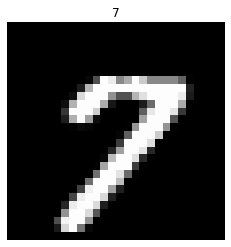

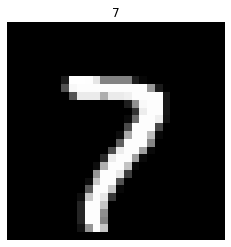

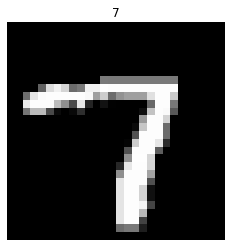

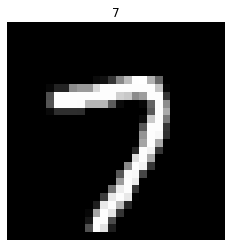

In [ ]:
tdl.show_batch((x,y))

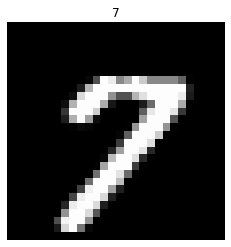

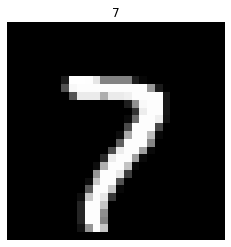

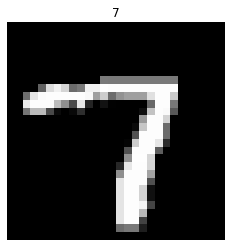

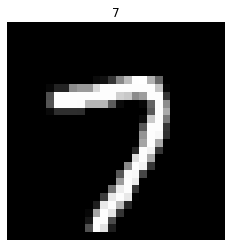

In [ ]:
x,y = torch.add(x,0),torch.add(y,0) #Lose type of tensors (to emulate predictions)
test_ne(type(x), TensorImage)
tdl.show_batch((x,y), figsize=(4,4)) #Check that types are put back by dl.

In [ ]:
#TODO: make the above check a proper test

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_test.ipynb.
Converted 01_core_foundation.ipynb.
Converted 01a_core_utils.ipynb.
Converted 01b_core_dispatch.ipynb.
Converted 01c_core_transform.ipynb.
Converted 02_core_script.ipynb.
Converted 03_torchcore.ipynb.
Converted 03a_layers.ipynb.
Converted 04_data_load.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_data_block.ipynb.
Converted 08_vision_core.ipynb.
Converted 09_vision_augment.ipynb.
Converted 09a_vision_data.ipynb.
Converted 09b_vision_utils.ipynb.
Converted 10_pets_tutorial.ipynb.
Converted 11_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 13a_metrics.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 14a_callback_data.ipynb.
Converted 15_callback_hook.ipynb.
Converted 15a_vision_models_unet.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_interpret.ipynb.
C